In [1]:
from IPython.display import display, Latex, Markdown
import numpy as np
from numpy import linalg as LA
import sympy as sp
import lcapy as lcp
import control as ctrl
from control import matlab
import math
import cmath
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
                     'figure.figsize':[13.24,9],
                     'font.size': 22, 
                     'xaxis.labellocation': 'right',
                     'yaxis.labellocation': 'top'});

def root2poly(symbol, *roots):
    x = sp.symbols(str(symbol));
    poly = 1;
    for root in roots:
        poly *=(x-root);
    return poly.expand();
    
def relative_error(reference, value): 
    return abs((value-reference)/reference)*100;
    
def overshoot(signal):
    return relative_error(signal[-1], max(signal));

def settling_time(signal, t, percentage):
    delta = lambda x: abs((x[-1]-x)/x[-1]);
    absolute_difference = lambda x, idx, percentage: abs(x[idx]-x[-1]-percentage*x[-1]);
    
    idx = np.argwhere(delta(signal) > percentage)[-1][0];
    if absolute_difference(signal,idx,percentage) < absolute_difference(signal,idx+1,percentage):
        st = t[idx];
    else:
        st = t[idx+1];
    
    return st;

# 1.a) Modelagem do sistema no espaço de estados:

### Obtenha a representação no espaço de estados do circuito.

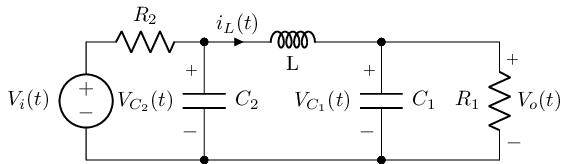

<h3> Onde:                      <ul>                           <li> R1 = 5 $\Omega$; </li>                           <li> R2 = 5 $\Omega$; </li>                           <li> C1 = 1000 $\mathrm{uF}$; </li>                           <li> C2 = 1000 $\mathrm{uF}$; </li>                           <li> L = 20 $\mathrm{mH}$; </li>                      </ul>                  </h3>

### E as variáveis de estado $x_{1}$, $x_{2}$ e $x_{3}$ são,                  respectivamente $V_{C_{1}}(t)$, $V_{C_{2}}(t)$ e $i_{L}(t)$.

In [2]:
# Sistema a ser modelado, observado e controlado:

circuito = lcp.Circuit("""
V 1 0 step 1; down, l_={V_{i}(t)}
R2 1 2 R1; right, scale=0.8, l^=R_2
C2 2 0_2 C2; down, scale=0.8, l^=C_2, v_={V_{C_{2}}(t)}
L 2 3 L; right, size=1.5, scale=0.8, l_=L, i>^={i_{L}(t)}
C1 3 0_3 C1; down, scale=0.8, l^=C_1, v_={V_{C_{1}}(t)}
W 3 4; right
R1 4 0_4 R1; down, scale=0.8, l_=R_1, v^={V_{o}(t)}
W 0 0_2; right
W 0_2 0_3; right
W 0_3 0_4; right
; draw_nodes=connections, label_ids=none, label_nodes=none""");

display(Markdown('### Obtenha a representação no espaço de estados do circuito.'));
circuito.draw();
display(Markdown('<h3> Onde: \
                     <ul> \
                          <li> R1 = 5 $\Omega$; </li> \
                          <li> R2 = 5 $\Omega$; </li> \
                          <li> C1 = 1000 $\mathrm{uF}$; </li> \
                          <li> C2 = 1000 $\mathrm{uF}$; </li> \
                          <li> L = 20 $\mathrm{mH}$; </li> \
                     </ul> \
                 </h3>'));
display(Markdown('### E as variáveis de estado $x_{1}$, $x_{2}$ e $x_{3}$ são, \
                 respectivamente $V_{C_{1}}(t)$, $V_{C_{2}}(t)$ e $i_{L}(t)$.'));

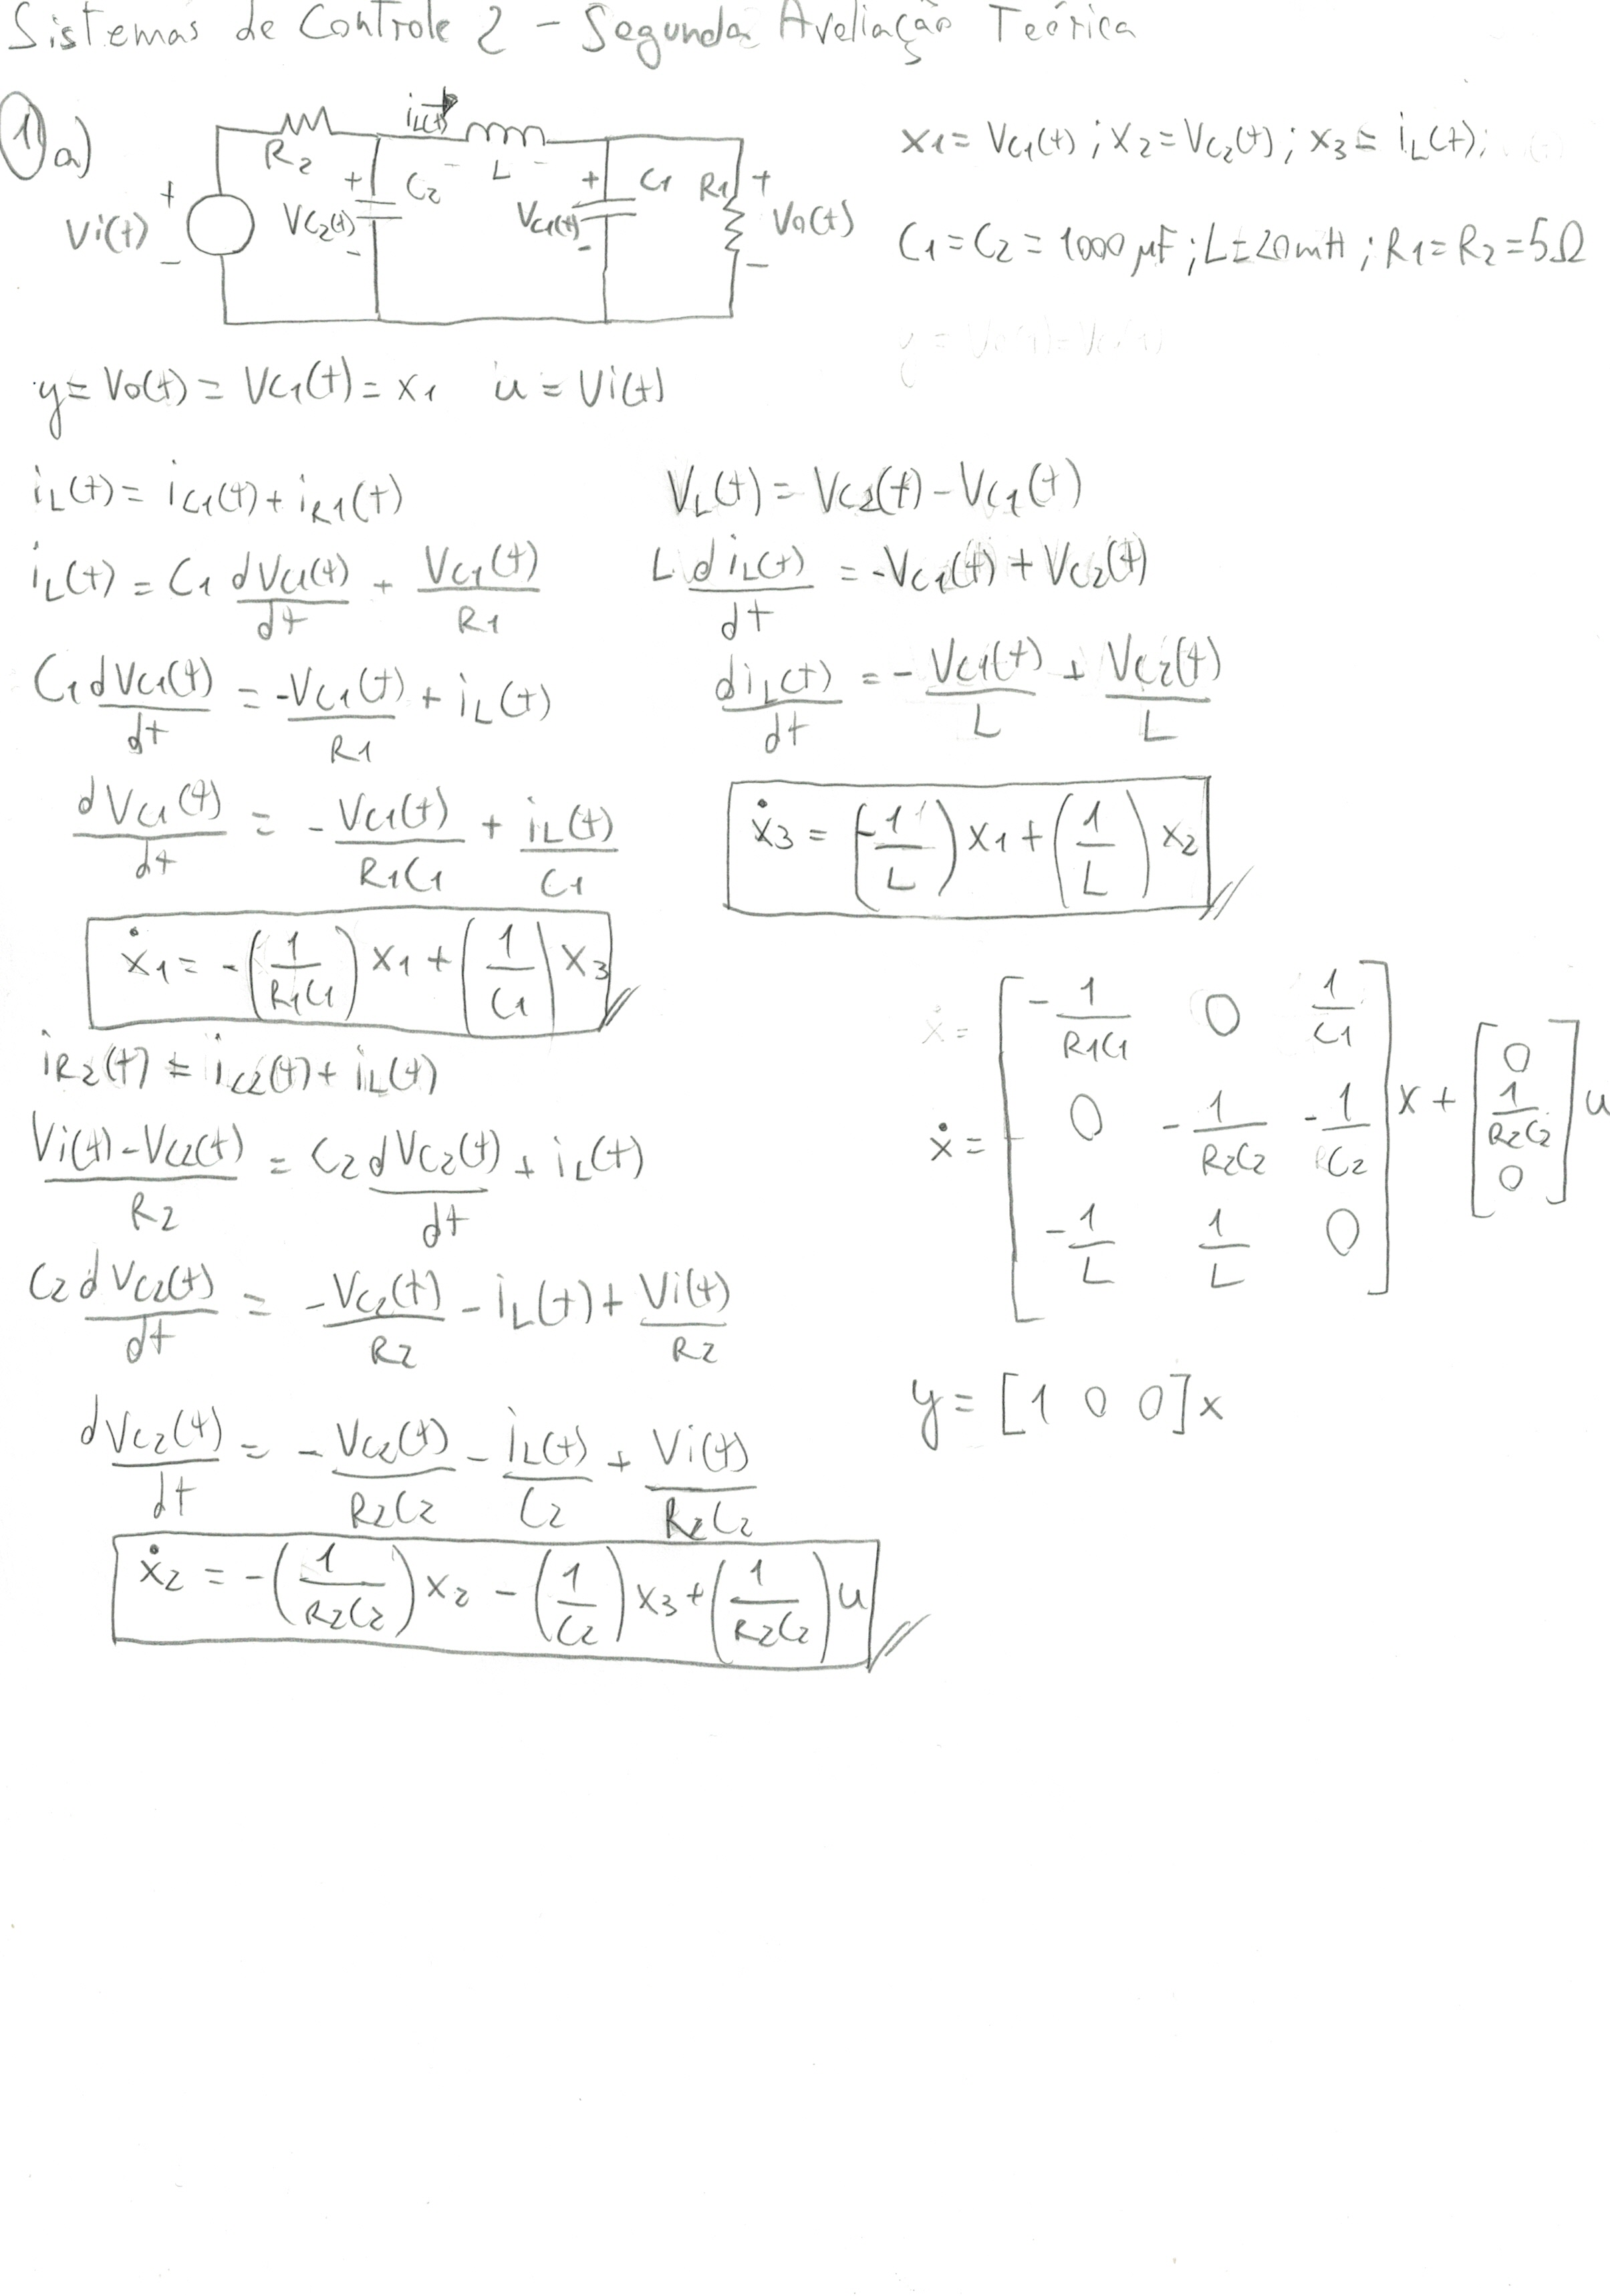

In [3]:
# Espaço de estados do sistema:

sistema = circuito.ss;

R1 = lcp.symbol('R1', positive=True);
R2 = lcp.symbol('R2', positive=True);
C1 = lcp.symbol('C1', positive=True);
C2 = lcp.symbol('C2', positive=True);
L = lcp.symbol('L', positive=True);

vetor = lcp.Matrix([sistema.x[2,::-1], sistema.x[1,::-1], sistema.x[0,::-1]]);
A = lcp.Matrix([sistema.A[2,::-1], sistema.A[1,::-1], sistema.A[0,::-1]]);
B = lcp.Matrix([sistema.B[2,0], sistema.B[1,0], sistema.B[0,0]]);
C = sistema.C[2,::-1];
D = sistema.D[2,:];

display(Markdown('### Vetor de estados:'));
display(Latex('$ \mathbf{x} = '+str(vetor.latex())+'$'));
display(Markdown('### Matriz de estados:'));
display(Latex('$ \mathbf{A} = '+str(A.latex())+'$'));
display(Markdown('### Matriz de entrada:'));
display(Latex('$ \mathbf{B} = '+str(B.latex())+'$'));
display(Markdown('### Matriz de saída:'));
display(Latex('$ \mathbf{C} = '+str(C.latex())+'$'));
display(Markdown('### Matriz de transmissão direta:'));
display(Latex('$ \mathbf{D} = '+str(D.latex())+'$'));
display(Markdown('### Representação no espaço de estados:'));
display(Latex('$ \mathbf{\dot{x}} = '+str(A.latex())+'\mathbf{x}+'+str(B.latex())+'u(t)$'));
display(Latex('$y = '+str(C.latex())+'\mathbf{x}$'));

### Vetor de estados:

<IPython.core.display.Latex object>

### Matriz de estados:

<IPython.core.display.Latex object>

### Matriz de entrada:

<IPython.core.display.Latex object>

### Matriz de saída:

<IPython.core.display.Latex object>

### Matriz de transmissão direta:

<IPython.core.display.Latex object>

### Representação no espaço de estados:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
# Substituição de valores no espaço de estados do sistema:

defs = {R1 : 5, R2 : 5, C1 : 1000e-6, C2 : 1000e-6, L : 20e-3};

A = A.subs(defs);
B = B.subs(defs);
C = C.subs(defs);
D = D.subs(defs);

display(Markdown('### Vetor de estados:'));
display(Latex('$ \mathbf{x} = '+str(vetor.latex())+'$'));
display(Markdown('### Matriz de estados:'));
display(Latex('$ \mathbf{A} = '+str(A.latex()).replace('.',',')+'$'));
display(Markdown('### Matriz de entrada:'));
display(Latex('$ \mathbf{B} = '+str(B.latex()).replace('.',',')+'$'));
display(Markdown('### Matriz de saída:'));
display(Latex('$ \mathbf{C} = '+str(C.latex()).replace('.',',')+'$'));
display(Markdown('### Matriz de transmissão direta:'));
display(Latex('$ \mathbf{D} = '+str(D.latex()).replace('.',',')+'$'));
display(Markdown('### Representação no espaço de estados:'));
display(Latex('$ \mathbf{\dot{x}} = '+str(A.latex()).replace('.',',')+
              '\mathbf{x}+'+str(B.latex()).replace('.',',')+'u(t)$'));
display(Latex('$y = '+str(C.latex()).replace('.',',')+'\mathbf{x}$'));

### Vetor de estados:

<IPython.core.display.Latex object>

### Matriz de estados:

<IPython.core.display.Latex object>

### Matriz de entrada:

<IPython.core.display.Latex object>

### Matriz de saída:

<IPython.core.display.Latex object>

### Matriz de transmissão direta:

<IPython.core.display.Latex object>

### Representação no espaço de estados:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
A = np.matrix(A.tolist(), dtype=np.float64);
B = np.matrix(B.tolist(), dtype=np.float64);
C = np.matrix(C.tolist(), dtype=np.float64);
D = np.matrix(D.tolist(), dtype=np.float64);

s = sp.symbols('s');
I = sp.Matrix(np.eye(3));

ec = (s*I-A).det();
polos = sp.polys.polytools.nroots(ec);
ec_d = root2poly(s, *polos[1:]);
wn = sp.sqrt(ec_d.coeff(s, 0));
zeta = ec_d.coeff(s, 1)/(2*wn);
wd = wn*sp.sqrt(1-zeta**2);
Ta = ((wd/(2*np.pi))**(-1))/30;

display(Markdown('### Equação característica do sistema:'));
display(Latex('$ \mathrm{EC(s)} = '+str(sp.latex(ec)).replace(',', ';').replace('.',',')+'$'));
display(Markdown('### Polos do sistema:'));
display(Latex('$ \mathrm{polos} = '+str(sp.latex(list(polos))).replace(',', ';').replace('.',',')+'$'));
display(Markdown('### Frequência natural:'));
display(Latex('$ \mathrm{\omega_{n}} = '+str(sp.latex(wn)).replace('.',',')+' \, \mathrm{rad/s}$'));
display(Markdown('### Fator de amortecimento:'));
display(Latex('$ \mathrm{\zeta} = '+str(sp.latex(zeta)).replace('.',',')+'$'));
display(Markdown('### Frequência das oscilações senoidais amortecidas:'));
display(Latex('$ \mathrm{\omega_{d}} = '+str(sp.latex(wd)).replace('.',',')+' \, \mathrm{rad/s}$'));
display(Markdown('### Tempo de amostragem:'));
display(Latex('$ \mathrm{T_{a}} \leq '+str(sp.latex(Ta)).replace('.',',')+' \, \mathrm{s}$'));

### Equação característica do sistema:

<IPython.core.display.Latex object>

### Polos do sistema:

<IPython.core.display.Latex object>

### Frequência natural:

<IPython.core.display.Latex object>

### Fator de amortecimento:

<IPython.core.display.Latex object>

### Frequência das oscilações senoidais amortecidas:

<IPython.core.display.Latex object>

### Tempo de amostragem:

<IPython.core.display.Latex object>

# 1.b) Simulação da resposta ao degrau unitário do sistema original por equações recursivas:

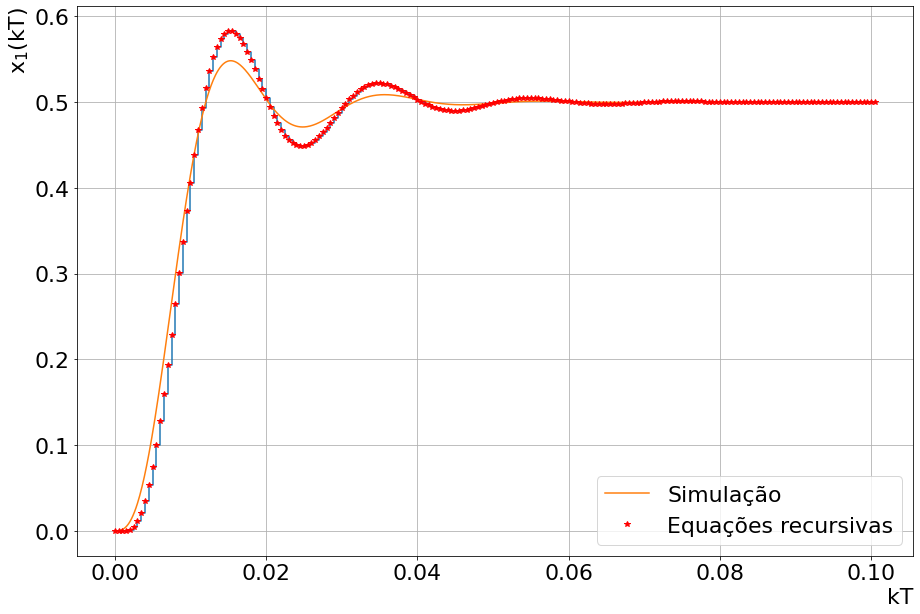

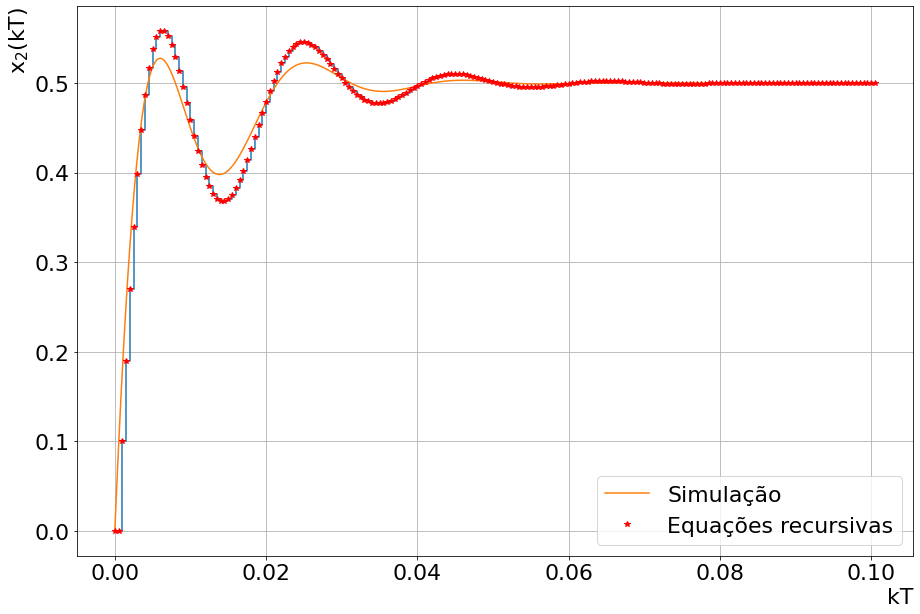

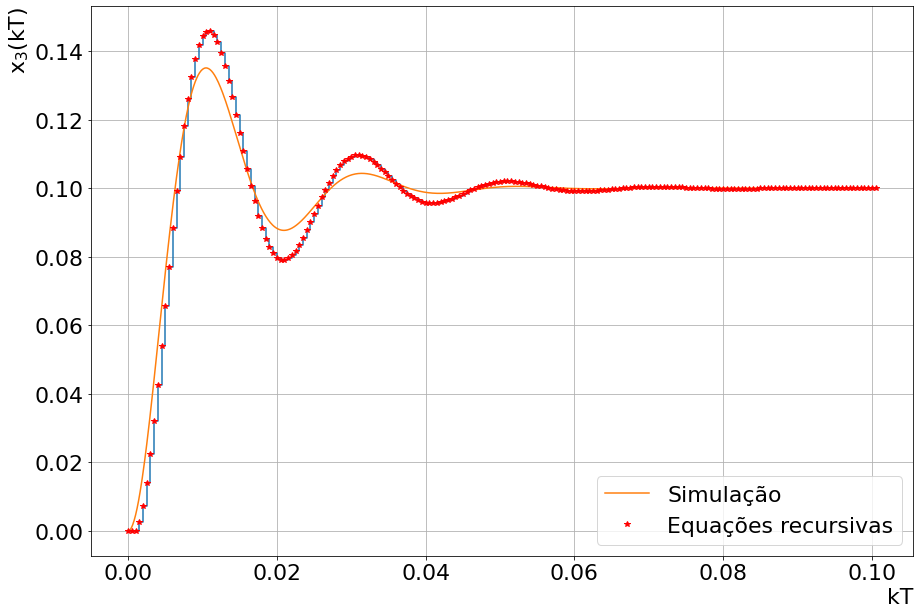

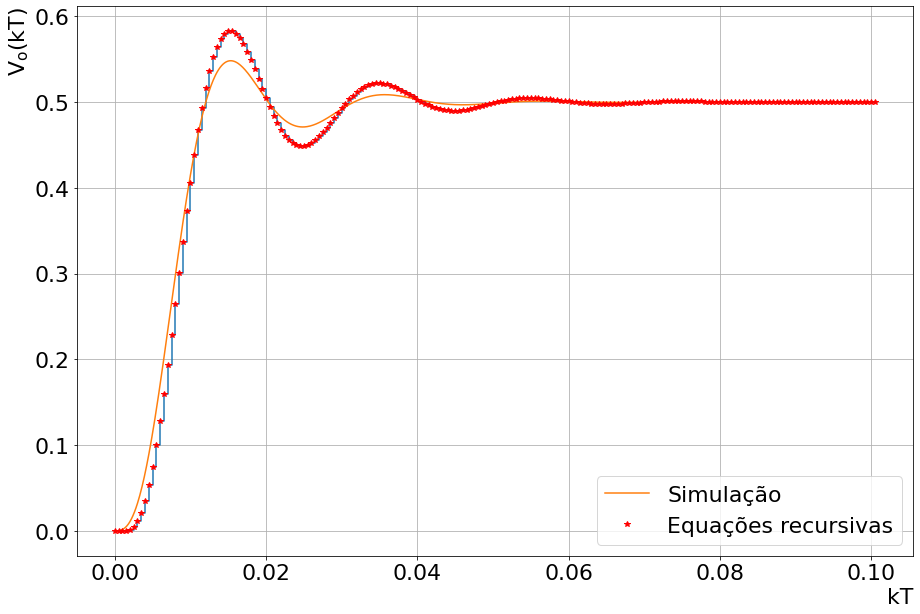

In [6]:
# Simulação do sistema original:

# Amplitude do degrau de entrada.

amplitude = 1.0;

# Sistema de espaço de estados.

sys = ctrl.ss(A,B,C,D);

# Condições Iniciais.

x0 = np.matrix([[0], [0], [0]]);

# Simulação do sistema.

t = np.linspace(0, 100e-3, 1000);
u = amplitude*np.heaviside(t, 1);
Y, t, X = ctrl.matlab.lsim(sys, u, t, x0);

# Simulação com discretização dos integradores.
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)=E(z)/E_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)
# e(k)=T*e_ponto(k-1)+e(k-1)

T = 5e-4;
tfinal = 100e-3;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1);
u = amplitude*np.heaviside(k, 1);

x1 = np.zeros_like(k);
x2 = np.zeros_like(k);
x3 = np.zeros_like(k);
x1_ponto = np.zeros_like(k);
x2_ponto = np.zeros_like(k);
x3_ponto = np.zeros_like(k);
y = np.zeros_like(k);

# Condições iniciais (podem ser diferentes de zero).

x1[0] = x0[0];  #  para k = 0
x2[0] = x0[1];  #  para k = 0
x3[0] = x0[2];  #  para k = 0
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
x3_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+C[0,2]*x3[0]+D[0,0]*u[0];  #  para k = 0

for j in range(1,Kmax+1):
    # Equações dos integradores:
    
    x1[j] = T*x1_ponto[j-1]+x1[j-1];
    x2[j] = T*x2_ponto[j-1]+x2[j-1];
    x3[j] = T*x3_ponto[j-1]+x3[j-1];    
    
    # Equação diferencial de estados:  Xponto=A*X+B*U
        
    x1_ponto[j] = A[0,0]*x1[j]+A[0,1]*x2[j]+A[0,2]*x3[j]+B[0,0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j]+A[1,1]*x2[j]+A[1,2]*x3[j]+B[1,0]*u[j];
    x3_ponto[j] = A[2,0]*x1[j]+A[2,1]*x2[j]+A[2,2]*x3[j]+B[2,0]*u[j]; 
    
    # Equação de Saída: Y=C*X+D*U
    
    y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+C[0,2]*x3[j]+D[0,0]*u[j];

# Comportamento da variável de estado x1(t).

plt.figure();
plt.plot(k*T, x1, ds='steps-post');
plt.plot(t, X.T[0], label='Simulação');
plt.plot(k*T, x1, 'r*', label='Equações recursivas');
plt.xlabel("kT");
plt.ylabel("$\mathrm{x_{1}(kT)}$");
plt.legend(loc='lower right');
plt.grid();
plt.tight_layout();
plt.show();

# Comportamento da variável de estado x2(t).

plt.figure();
plt.plot(k*T, x2, ds='steps-post');
plt.plot(t, X.T[1], label='Simulação');
plt.plot(k*T, x2, 'r*', label='Equações recursivas');
plt.xlabel("kT");
plt.ylabel("$\mathrm{x_{2}(kT)}$");
plt.legend(loc='lower right');
plt.grid();
plt.tight_layout();
plt.show();

# Comportamento da variável de estado x3(t).

plt.figure();
plt.plot(k*T, x3, ds='steps-post');
plt.plot(t, X.T[2], label='Simulação');
plt.plot(k*T, x3, 'r*', label='Equações recursivas');
plt.xlabel("kT");
plt.ylabel("$\mathrm{x_{3}(kT)}$");
plt.legend(loc='lower right');
plt.grid();
plt.tight_layout();
plt.show();

# Comportamento da saída y(t).

plt.figure();
plt.plot(k*T, y, ds='steps-post');
plt.plot(t, Y, label='Simulação');
plt.plot(k*T, y, 'r*', label='Equações recursivas');
plt.xlabel("kT");
plt.ylabel("$\mathrm{V_{o}(kT)}$");
plt.legend(loc='lower right');
plt.grid();
plt.tight_layout();
#plt.savefig('itemc.png', facecolor='w');
plt.show();

# 1.c) Projeto do observador de ordem mínima:

In [7]:
# Autovalores desejados:

autovalores = [-4*zeta*wn+1j*wn*math.sqrt(1-zeta**2), -4*zeta*wn-1j*wn*math.sqrt(1-zeta**2)];

# Escalar e matrizes do observador de ordem mínima:

Aaa = A[0,0];
Aab = A[0,1:];
Aba = A[1:,0];
Abb = A[1:,1:];
Ba = B[0,0];
Bb = B[1:,0];

# Matriz de observabilidade:
# N_min = np.block([np.conjugate(Aab).T, np.conjugate(Abb).T*np.conjugate(Aab).T]);
# Ou opcionalmente:
# N_min = ctrl.obsv(Abb, Aab);

N_min = (np.block([np.conjugate(Aab).T, np.conjugate(Abb).T*np.conjugate(Aab).T])).T;

# Equação característica desejada:

s, I = sp.symbols('s I');

eq_des = root2poly(s, *autovalores);

# Substituição da matriz Abb no polinômio desejado phi:

ordem = sp.degree(eq_des);
eq_tmp = eq_des - eq_des.coeff(s, 0) + eq_des.coeff(s,0)*I;
eq_tmp = eq_tmp.xreplace({I : sp.Matrix(np.eye(ordem))});

phi = sp.lambdify(s, eq_tmp, 'numpy');

# Fórmula de Ackreman:
# Ke = phi(Abb)*LA.inv(N_min)*k;

k = (np.matrix([np.zeros(ordem)])).T;
k[-1, 0] = 1;
Ke = phi(Abb)*LA.inv(N_min)*k;

autovalores_min = LA.eig(Abb-Ke*Aab)[0];

A_min = Abb-Ke*Aab;
B_min = (Abb-Ke*Aab)*Ke+Aba-Ke*Aaa;
F_min = Bb-Ke*Ba;
C_min = np.block([[np.zeros((1, ordem))], [np.eye(ordem)]]);
D_min = np.block([[1], [Ke]]);

display(Markdown('### Escalar $A_{aa}$:'));
display(Latex('$ A_{aa} = '+str(sp.latex(Aaa)).replace('.',',')+'$'));
display(Markdown('### Matriz $\mathbf{A}_{ab}$:'));
display(Latex('$ \mathbf{A}_{ab} = '+str(sp.latex(sp.Matrix(Aab))).replace('.',',')+'$'));
display(Markdown('### Matriz $\mathbf{A}_{ba}$:'));
display(Latex('$ \mathbf{A}_{ba} = '+str(sp.latex(sp.Matrix(Aba))).replace('.',',')+'$'));
display(Markdown('### Matriz $\mathbf{A}_{bb}$:'));
display(Latex('$ \mathbf{A}_{bb} = '+str(sp.latex(sp.Matrix(Abb))).replace('.',',')+'$'));
display(Markdown('### Matriz de controlabilidade do observador de ordem mínima:'));
display(Latex('$ \mathbf{\hat{N}} = '+str(sp.latex(sp.Matrix(N_min))).replace('.',',')+'$'));
display(Markdown('### Matriz $\phi({\mathbf{A}_{bb}})$:'));
display(Latex('$ \phi({\mathbf{A}_{bb}}) = '+str(sp.latex(sp.Matrix(phi(Abb)))).replace('.',',')+'$'));
display(Markdown('### Matriz de ganho do observador de ordem mínima:'));
display(Latex('$ \mathbf{K}_{e} = '+str(sp.latex(sp.Matrix(Ke))).replace('.',',')+'$'));
display(Markdown('### Autovalores desejados:'));
display(Markdown('$ \mathbf{\mu} = '+str(autovalores).replace(',','; \ ').replace('.',',')+'$'));
display(Markdown('### Polinômio característico desejado:'));
display(Latex('$ \mathrm{EC(s)} = '+str(sp.latex(eq_des)).replace('.', ',')+'$'))
display(Markdown('### Autovalores obtidos:'));
display(Latex('$ \mathbf{\hat{\mu}} = '+str(list(autovalores_min)).replace(',','; \ ').replace('.',',')+'$'));
display(Markdown('### Matriz $\mathbf{\hat{A}}$:'));
display(Latex('$ \mathbf{\hat{A}} = '+str(sp.latex(sp.Matrix(A_min))).replace('.',',')+'$'));
display(Markdown('### Matriz $\mathbf{\hat{B}}$:'));
display(Latex('$ \mathbf{\hat{B}} = '+str(sp.latex(sp.Matrix(B_min))).replace('.',',')+'$'));
display(Markdown('### Matriz $\mathbf{\hat{F}}$:'));
display(Latex('$ \mathbf{\hat{F}} = '+str(sp.latex(sp.Matrix(F_min))).replace('.',',')+'$'));
display(Markdown('### Matriz $\mathbf{\hat{C}}$:'));
display(Latex('$ \mathbf{\hat{C}} = '+str(sp.latex(sp.Matrix(C_min))).replace('.',',')+'$'));
display(Markdown('### Matriz $\mathbf{\hat{D}}$:'));
display(Latex('$ \mathbf{\hat{D}} = '+str(sp.latex(sp.Matrix(D_min))).replace('.',',')+'$'));

### Escalar $A_{aa}$:

<IPython.core.display.Latex object>

### Matriz $\mathbf{A}_{ab}$:

<IPython.core.display.Latex object>

### Matriz $\mathbf{A}_{ba}$:

<IPython.core.display.Latex object>

### Matriz $\mathbf{A}_{bb}$:

<IPython.core.display.Latex object>

### Matriz de controlabilidade do observador de ordem mínima:

<IPython.core.display.Latex object>

### Matriz $\phi({\mathbf{A}_{bb}})$:

<IPython.core.display.Latex object>

### Matriz de ganho do observador de ordem mínima:

<IPython.core.display.Latex object>

### Autovalores desejados:

$ \mathbf{\mu} = [-400,0 + 300,0*I; \  -400,0 - 300,0*I]$

### Polinômio característico desejado:

<IPython.core.display.Latex object>

### Autovalores obtidos:

<IPython.core.display.Latex object>

### Matriz $\mathbf{\hat{A}}$:

<IPython.core.display.Latex object>

### Matriz $\mathbf{\hat{B}}$:

<IPython.core.display.Latex object>

### Matriz $\mathbf{\hat{F}}$:

<IPython.core.display.Latex object>

### Matriz $\mathbf{\hat{C}}$:

<IPython.core.display.Latex object>

### Matriz $\mathbf{\hat{D}}$:

<IPython.core.display.Latex object>

In [8]:
AA = np.block([[A, np.zeros((len(A), ordem))], [B_min*C, A_min]]);
BB = np.block([[B], [F_min]]);
CC = np.block([[D_min*C, C_min]]);
DD = np.matrix(np.zeros((len(CC),1)));

display(Markdown('### Matriz de estados expandida:'));
display(Latex('$ \mathbf{A} = '+str(sp.latex(sp.Matrix(AA))).replace('.',',')+'$'));
display(Markdown('### Matriz de entrada expandida:'));
display(Latex('$ \mathbf{B} = '+str(sp.latex(sp.Matrix(BB))).replace('.',',')+'$'));
display(Markdown('### Matriz de saída expandida:'));
display(Latex('$ \mathbf{C} = '+str(sp.latex(sp.Matrix(CC))).replace('.',',')+'$'));
display(Markdown('### Matriz de transmissão direta expandida:'));
display(Latex('$ \mathbf{D} = '+str(sp.latex(sp.Matrix(DD))).replace('.',',')+'$'));
display(Markdown('### Representação no espaço de estados:'));
display(Latex('$ \\left[\\begin{matrix} \\mathbf{\\dot{x}} (t) \\\\ \\mathbf{\\dot{\\widetilde{\\eta}}} (t) \\end{matrix}\\right] = '+
              str(sp.latex(sp.Matrix(AA))).replace('.',',')+
              '\\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\mathbf{\\widetilde{\\eta}} (t) \\end{matrix}\\right]+'+
              str(sp.latex(sp.Matrix(BB))).replace('.',',')+'\mathbf{u} (t)$'));
display(Latex('$\mathbf{\widetilde{x}} (t) = '+str(sp.latex(sp.Matrix(CC))).replace('.',',')+
              '\\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\mathbf{\\widetilde{\\eta}} (t) \\end{matrix}\\right]$'));

### Matriz de estados expandida:

<IPython.core.display.Latex object>

### Matriz de entrada expandida:

<IPython.core.display.Latex object>

### Matriz de saída expandida:

<IPython.core.display.Latex object>

### Matriz de transmissão direta expandida:

<IPython.core.display.Latex object>

### Representação no espaço de estados:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# 1.d) Simulação da resposta ao degrau unitário do sistema observado por equações recursivas:

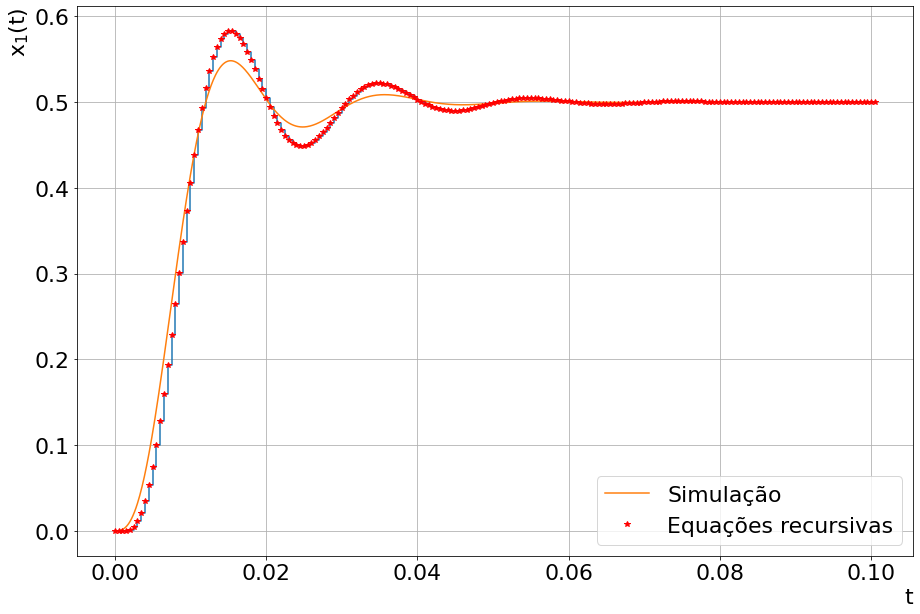

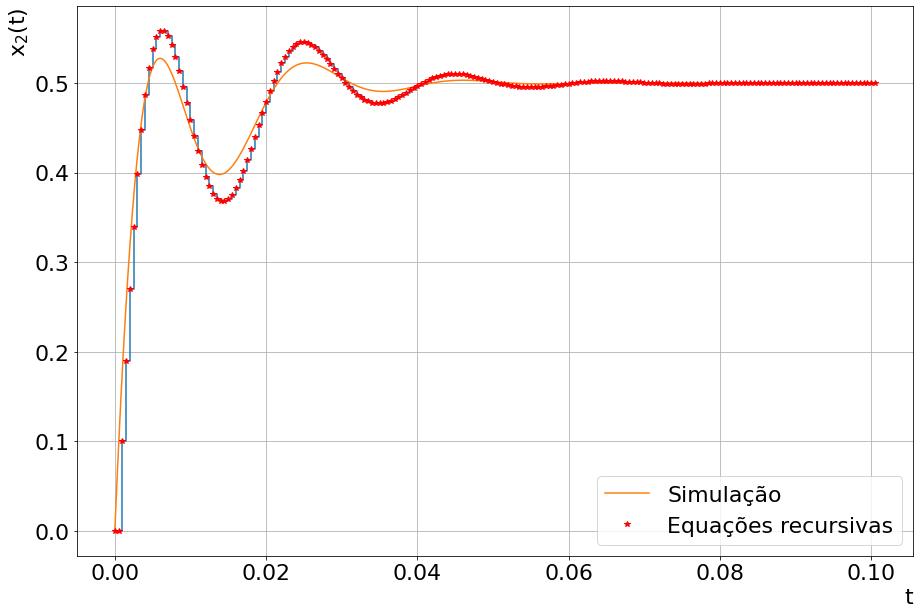

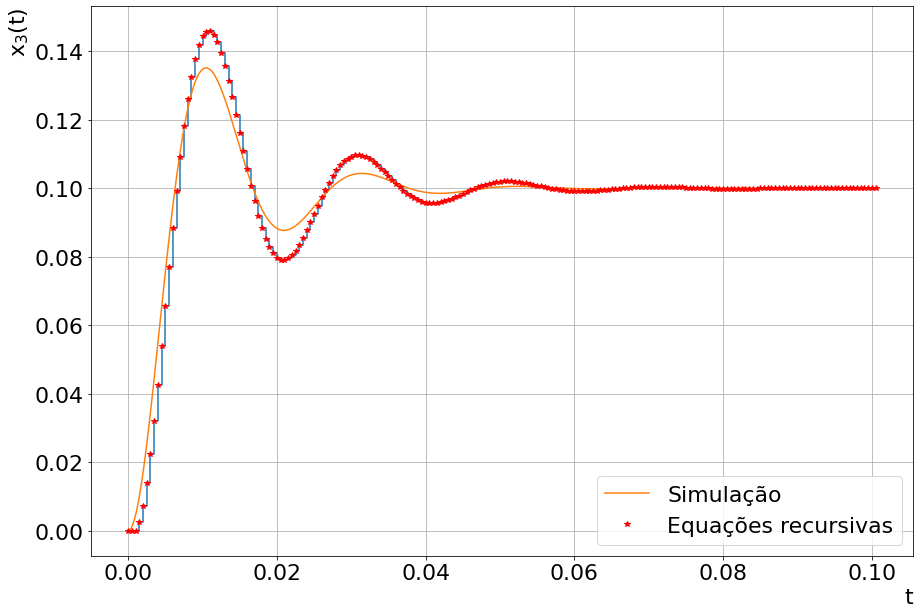

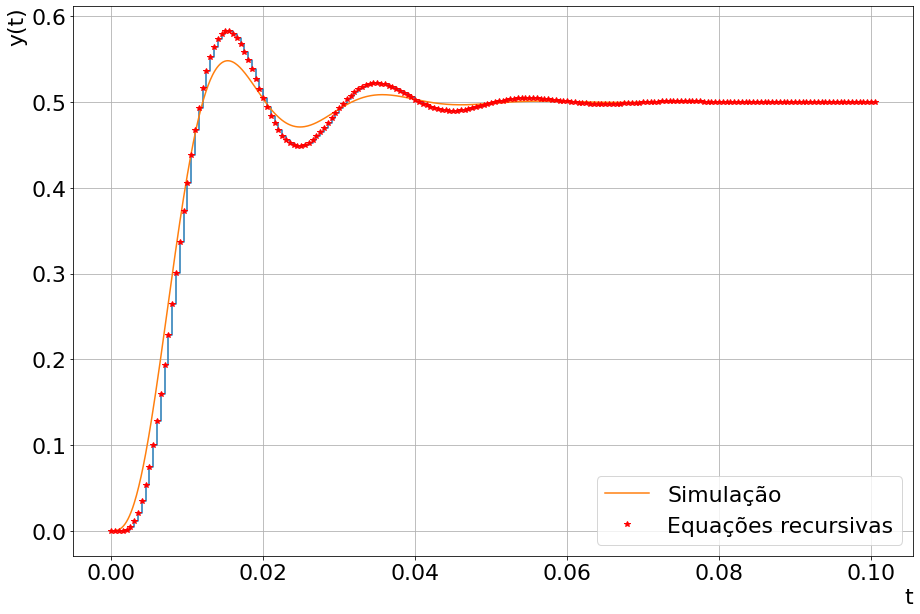

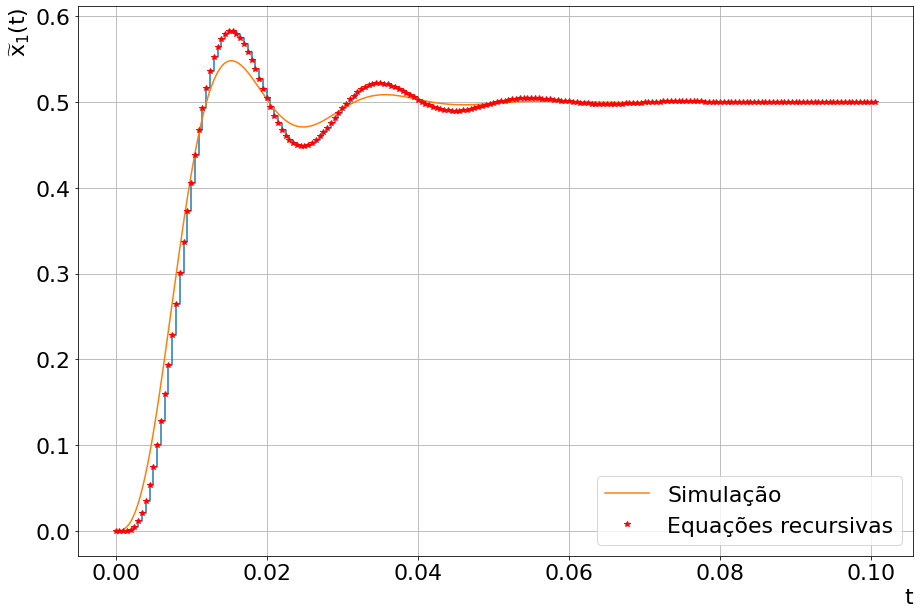

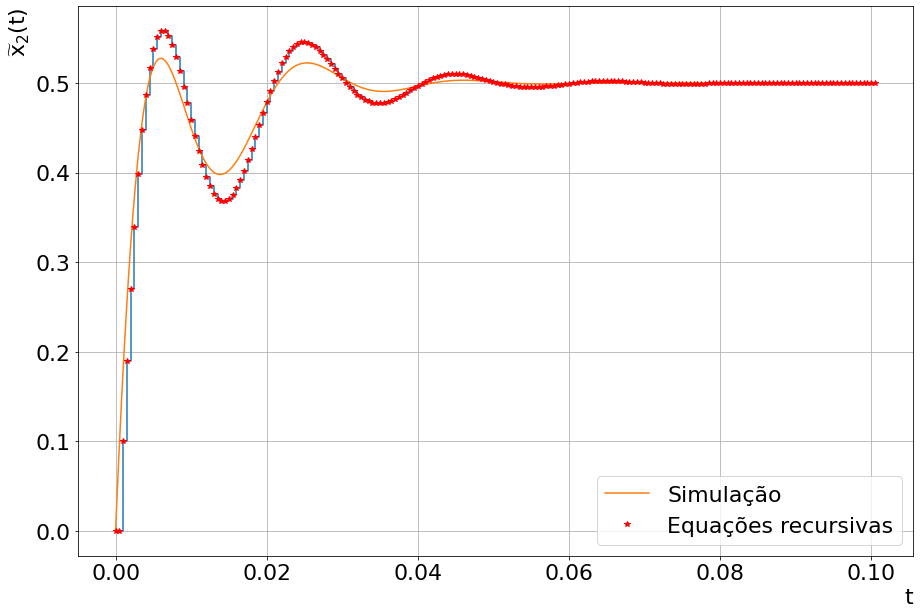

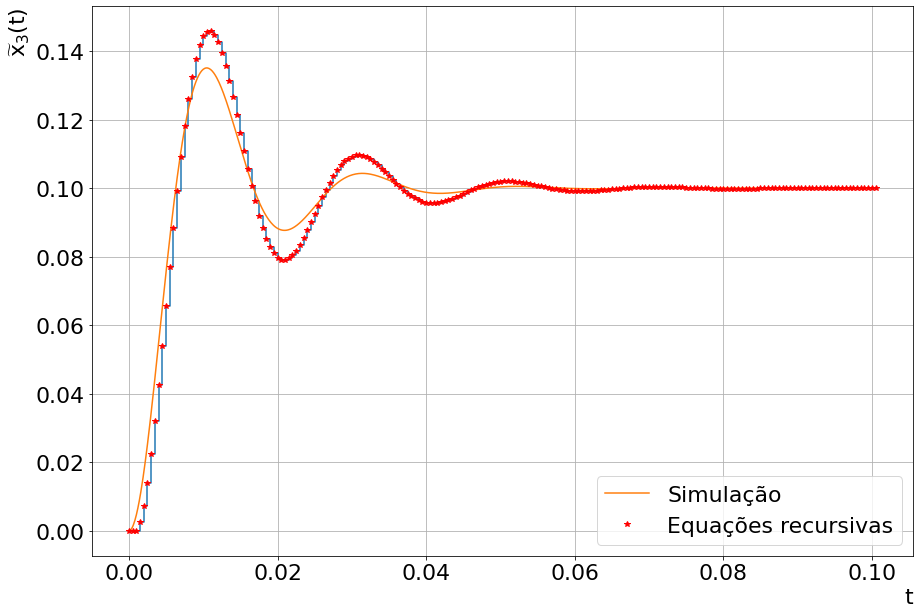

In [9]:
# Simulação do sistema controlado 'contínuo' e discreto com amplitude de 1,0 V para o sinal de entrada: 

# Amplitude do degrau de entrada.

amplitude = 1.0;

# Sistema expandido.

sistema_min = ctrl.ss(AA,BB,CC,DD);

# Condições Iniciais.

x0 = np.matrix([[0], [0], [0], [0], [0]]);

# Simulação do sistema.

t = np.linspace(0, 100e-3, 1000);
U = amplitude*np.heaviside(t,1);
Y, t, X = ctrl.matlab.lsim(sistema_min, U, t, x0);

X1a = X[:,0];
X1b = X[:,1];
X1c = X[:,2];
X1d = X[:,3];
X1e = X[:,4];

# Simulação com discretização dos integradores.
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)

T = 5e-4;
tfinal = 100e-3;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1);
u = amplitude*np.heaviside(k, 1);

x1 = np.zeros_like(k);
x2 = np.zeros_like(k);
x3 = np.zeros_like(k);
eta1 = np.zeros_like(k);
eta2 = np.zeros_like(k);
x1_ponto = np.zeros_like(k);
x2_ponto = np.zeros_like(k);
x3_ponto = np.zeros_like(k);
y = np.zeros_like(k);
eta1_ponto = np.zeros_like(k);
eta2_ponto = np.zeros_like(k);
x1e = np.zeros_like(k);
x2e = np.zeros_like(k);
x3e = np.zeros_like(k);

# Condições iniciais (podem ser diferentes de zero).

x1[0] = x0[0];  #  para k = 0
x2[0] = x0[1];  #  para k = 0
x3[0] = x0[2];  #  para k = 0
eta1[0] = x0[3];  #  para k = 0
eta2[0] = x0[4];  #  para k = 0
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
x3_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+C[0,2]*x3[0]+D[0,0]*u[0];  #  para k = 0
eta1_ponto[0] = x0[3];  #  para k = 0
eta2_ponto[0] = x0[4];  #  para k = 0
x1e[0] = 0; #  para k = 0
x2e[0] = 0; #  para k = 0
x3e[0] = 0; #  para k = 0

for j in range(1,Kmax+1):
    # Equações dos integradores:
    
    x1[j] = T*x1_ponto[j-1]+x1[j-1];
    x2[j] = T*x2_ponto[j-1]+x2[j-1];
    x3[j] = T*x3_ponto[j-1]+x3[j-1];
    eta1[j] = T*eta1_ponto[j-1]+eta1[j-1];
    eta2[j] = T*eta2_ponto[j-1]+eta2[j-1];    
    
    # Equação diferencial de estados:  Xponto=A*X+B*U
    
    x1_ponto[j] = A[0,0]*x1[j]+A[0,1]*x2[j]+A[0,2]*x3[j]+B[0,0]*u[j];
    x2_ponto[j] = A[1,0]*x1[j]+A[1,1]*x2[j]+A[1,2]*x3[j]+B[1,0]*u[j];
    x3_ponto[j] = A[2,0]*x1[j]+A[2,1]*x2[j]+A[2,2]*x3[j]+B[2,0]*u[j];
    
    # Equação de Saída: Y=C*X+D*U
    
    y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+C[0,2]*x3[j]+D[0,0]*u[j];
    
    # Equação diferencial de estados:  Nponto=A*N+B*Y+F*U
    
    eta1_ponto[j] = A_min[0,0]*eta1[j]+A_min[0,1]*eta2[j]+B_min[0,0]*y[j]+F_min[0,0]*u[j];
    eta2_ponto[j] = A_min[1,0]*eta1[j]+A_min[1,1]*eta2[j]+B_min[1,0]*y[j]+F_min[1,0]*u[j];
    
    # Equação de Saída: Xe=C*N+D*Y
    
    x1e[j] = C_min[0,0]*eta1[j]+C_min[0,1]*eta2[j]+D_min[0,0]*y[j];
    x2e[j] = C_min[1,0]*eta1[j]+C_min[1,1]*eta2[j]+D_min[1,0]*y[j];
    x3e[j] = C_min[2,0]*eta1[j]+C_min[2,1]*eta2[j]+D_min[2,0]*y[j];

# Comportamento do estado x1:

plt.figure();
plt.plot(k*T, x1, ds='steps-post');
plt.plot(t, X1a, label='Simulação');
plt.plot(k*T, x1,'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do estado x2:

plt.figure();
plt.plot(k*T, x2, ds='steps-post');
plt.plot(t, X1b, label='Simulação');
plt.plot(k*T, x2, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do estado x3:

plt.figure();
plt.plot(k*T, x3, ds='steps-post');
plt.plot(t, X1c, label='Simulação');
plt.plot(k*T, x3, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{3}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída y:

plt.figure();
plt.plot(k*T, y, ds='steps-post');
plt.plot(t, Y.T[0], label='Simulação');
plt.plot(k*T, y, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("y(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x1e:

plt.figure();
plt.plot(k*T, x1e, ds='steps-post');
plt.plot(t, Y.T[0], label='Simulação');
plt.plot(k*T, x1e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x2e:

plt.figure();
plt.plot(k*T, x2e, ds='steps-post');
plt.plot(t, Y.T[1], label='Simulação');
plt.plot(k*T, x2e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da estado x3e:

plt.figure();
plt.plot(k*T, x3e, ds='steps-post');
plt.plot(t, Y.T[2], label='Simulação');
plt.plot(k*T, x3e, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{\\widetilde{x}_{3}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# 1.e) Projeto do sistema controlado:

In [10]:
# Avaliação da controlabilidade do espaço de estados do sistema:

# Matriz de Controlabilidade

Mc = np.block([[A, B],[-C, 0]]);

display(Markdown('### Matrix de controlabilidade:'));
display(Latex('$ \mathbf{M_{c}} = '+str(sp.latex(sp.Matrix(Mc))).replace('.',',')+' $'));
display(Markdown('### Posto da matriz de controlabilidade:'));
display(Latex('$ \mathrm{posto} \, (\mathbf{M_{c}}) = '+str(np.linalg.matrix_rank(Mc))+' $'));
display(Markdown('### O sistema é de estados completamente controláveis.'));

### Matrix de controlabilidade:

<IPython.core.display.Latex object>

### Posto da matriz de controlabilidade:

<IPython.core.display.Latex object>

### O sistema é de estados completamente controláveis.

In [11]:
# Coeficientes do sistema.

wn = 500;
zeta = 0.7;
Mp = math.e**(-(math.pi*zeta)/math.sqrt(1-zeta**2));
tp = np.pi/(wn*np.sqrt(1-zeta**2));

display(Markdown('## Especificações do sistema controlado:'));
display(Markdown('### Sobressinal desejado:'));
display(Latex('$ M_{p\%} = '+str(Mp*100).replace('.',',')+'\, \%$'));
display(Markdown('### Instante de pico:'));
display(Latex('$ t_{p} = '+str(tp).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário desejado:'));
display(Latex('$ e(\infty) = 0$'));

## Especificações do sistema controlado:

### Sobressinal desejado:

<IPython.core.display.Latex object>

### Instante de pico:

<IPython.core.display.Latex object>

### Erro para um degrau unitário desejado:

<IPython.core.display.Latex object>

In [12]:
# Autovalores desejados:

wn = 500;
zeta = 0.7;

autovalores = [-zeta*wn+1j*wn*math.sqrt(1-zeta**2), -zeta*wn-1j*wn*math.sqrt(1-zeta**2), -10*zeta*wn, -10*zeta*wn];

# Matrizes expandidas:

A_servo = np.block([[A, np.zeros_like(C.T)],[-C, 0]]);
B_servo = np.block([[B],[0]]);

# Matriz de ganhos do controlador K_servo = [k1 k2 -ki]:

K_servo = ctrl.acker(A_servo, B_servo, autovalores);
autovalores_servo = LA.eig(A_servo-B_servo*K_servo)[0];

display(Markdown('### Matriz de estados expandida:'));
display(Latex('$ \mathbf{\hat{A}} = '+str(sp.latex(sp.Matrix(A_servo))).replace('.',',')+'$'));
display(Markdown('### Matriz de entrada expandida:'));
display(Latex('$ \mathbf{\hat{B}} = '+str(sp.latex(sp.Matrix(B_servo))).replace('.',',')+'$'));
display(Markdown('### Matriz de realimentação de estados expandida:'));
display(Latex('$ \mathbf{\hat{K}} = '+str(sp.latex(sp.Matrix(K_servo))).replace('.',',')+'$'));
display(Markdown('### Autovalores desejados:'));
display(Markdown('$ \mathbf{\mu} = '+str(autovalores).replace(',','; \ ').replace('.',',')+'$'));
display(Markdown('### Polinômio característico desejado:'));
display(Latex('$ EC(s) = '+str(sp.latex(root2poly(s, *autovalores))).replace('.', ',')+'$'))
display(Markdown('### Autovalores obtidos:'));
display(Latex('$ \mathbf{\hat{\mu}} = '+str(list(autovalores_servo)).replace(',','; \ ').replace('.',',')+'$'));

### Matriz de estados expandida:

<IPython.core.display.Latex object>

### Matriz de entrada expandida:

<IPython.core.display.Latex object>

### Matriz de realimentação de estados expandida:

<IPython.core.display.Latex object>

### Autovalores desejados:

$ \mathbf{\mu} = [(-350+357,07142142714247j); \  (-350-357,07142142714247j); \  -3500,0; \  -3500,0]$

### Polinômio característico desejado:

<IPython.core.display.Latex object>

### Autovalores obtidos:

<IPython.core.display.Latex object>

In [13]:
K = K_servo.tolist()[0];
K = np.matrix([k for k in K[0:len(K)-1]]);
ki = -(K_servo.tolist()[0][-1]);
AA = np.block([[A-B*K, B*ki],[-C, 0]]);
BB = np.matrix(np.array([[*np.zeros(len(autovalores))]]).T);
BB[-1] = 1;
CC = np.matrix(C.tolist()[0]+[float(0)]);
DD = np.matrix([float(0)]);

display(Markdown('### Matriz de estados expandida:'));
display(Latex('$ \mathbf{A} = '+str(sp.latex(sp.Matrix(AA))).replace('.',',')+'$'));
display(Markdown('### Matriz de entrada expandida:'));
display(Latex('$ \mathbf{B} = '+str(sp.latex(sp.Matrix(BB))).replace('.',',')+'$'));
display(Markdown('### Matriz de saída expandida:'));
display(Latex('$ \mathbf{C} = '+str(sp.latex(sp.Matrix(CC))).replace('.',',')+'$'));
display(Markdown('### Matriz de transmissão direta expandida:'));
display(Latex('$ \mathbf{D} = '+str(sp.latex(sp.Matrix(DD))).replace('.',',')+'$'));
display(Markdown('### Representação no espaço de estados:'));
display(Latex('$ \\left[\\begin{matrix} \\mathbf{\\dot{x}} (t) \\\\ \\dot{\\xi} (t) \\end{matrix}\\right] = '+
              str(sp.latex(sp.Matrix(AA))).replace('.',',')+
              '\\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\xi (t) \\end{matrix}\\right]+'+
              str(sp.latex(sp.Matrix(BB))).replace('.',',')+'r(t)$'));
display(Latex('$y = '+str(sp.latex(sp.Matrix(CC))).replace('.',',')+
              '\\left[\\begin{matrix} \\mathbf{x} (t) \\\\ \\xi (t) \\end{matrix}\\right]$'));

### Matriz de estados expandida:

<IPython.core.display.Latex object>

### Matriz de entrada expandida:

<IPython.core.display.Latex object>

### Matriz de saída expandida:

<IPython.core.display.Latex object>

### Matriz de transmissão direta expandida:

<IPython.core.display.Latex object>

### Representação no espaço de estados:

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Simulação da resposta ao degrau unitário do sistema controlado:

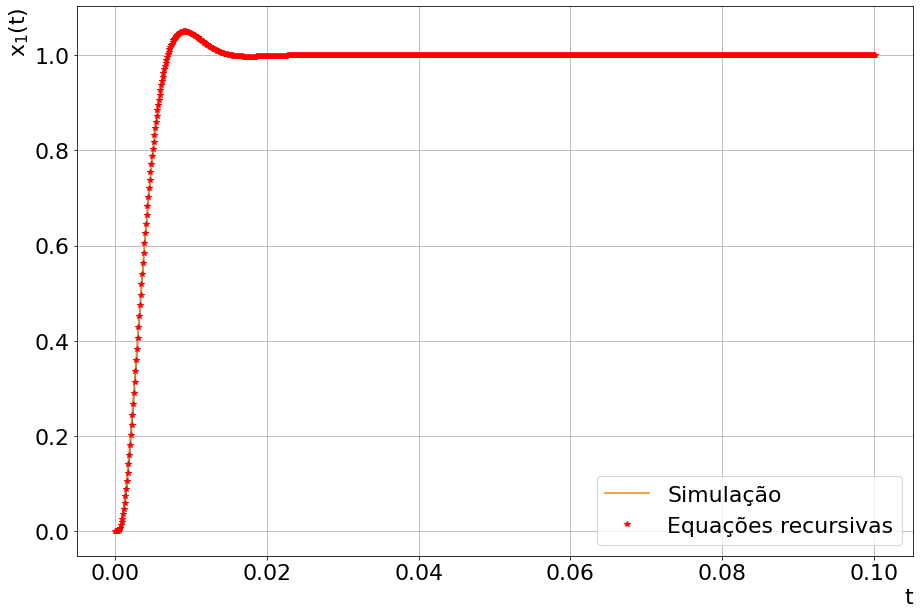

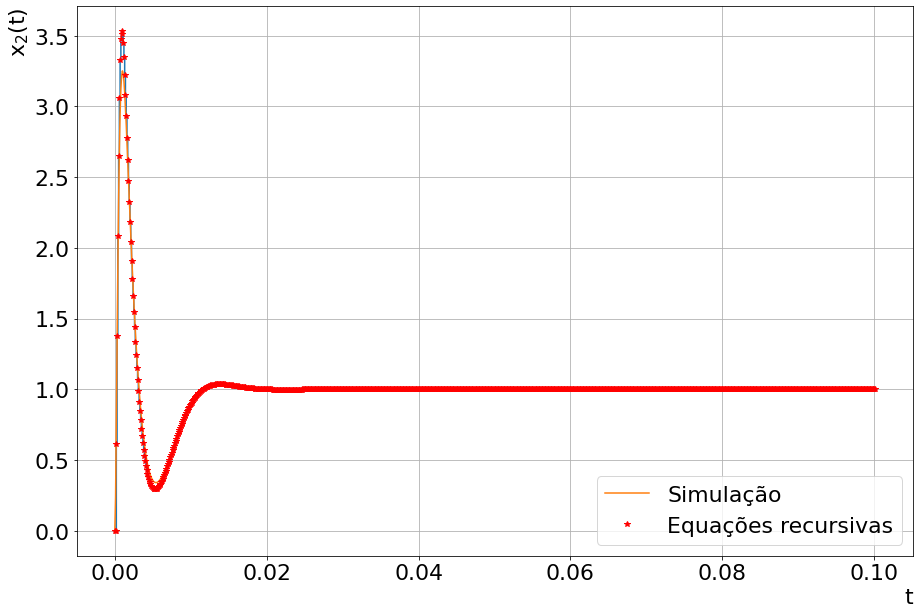

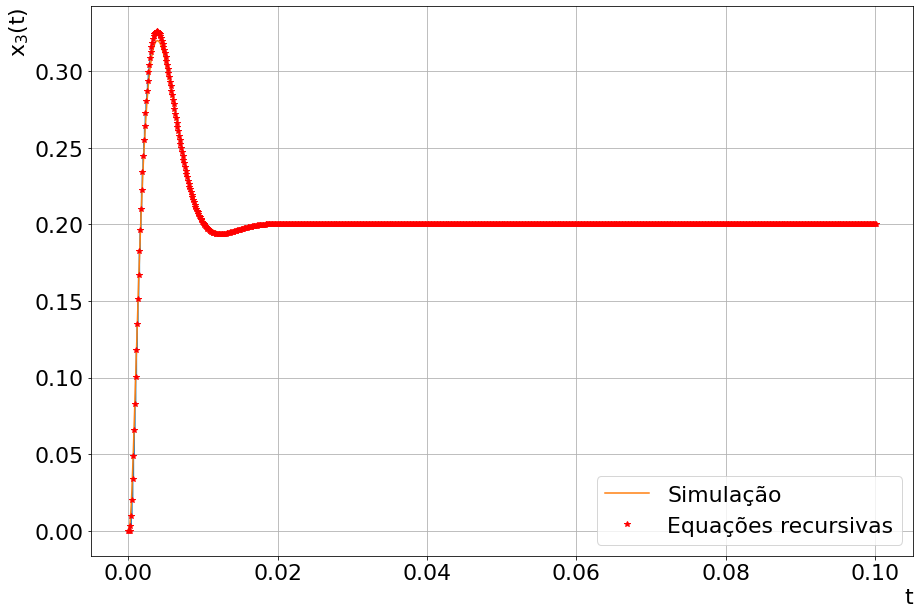

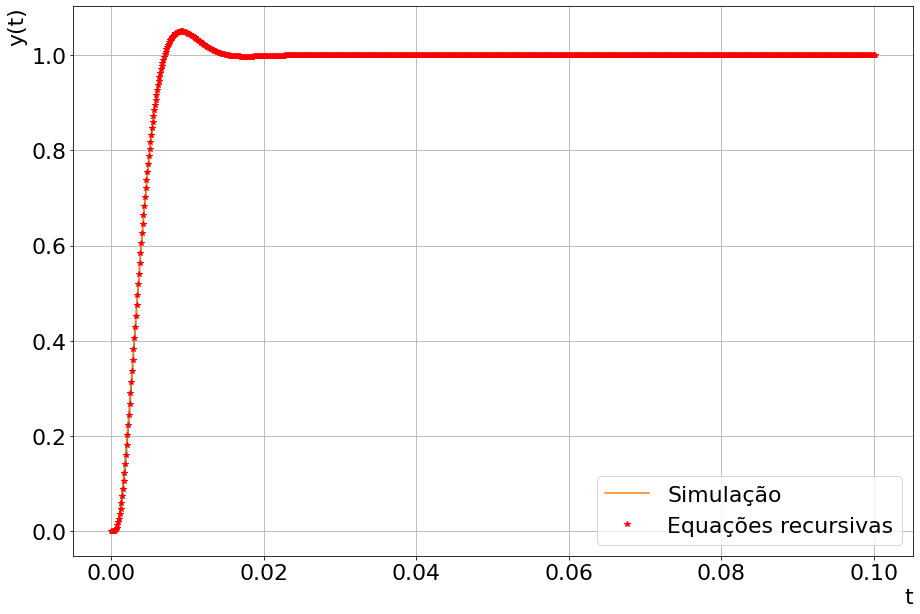

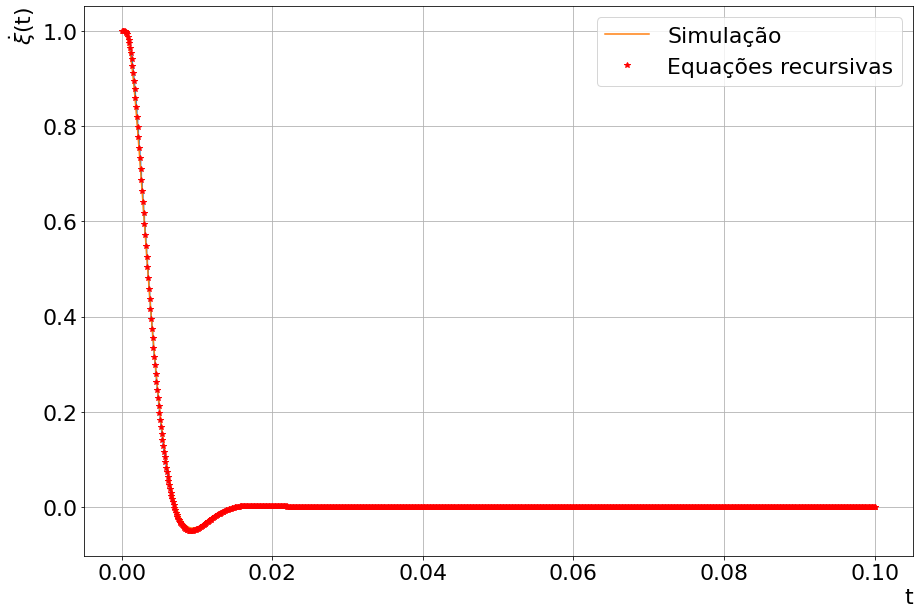

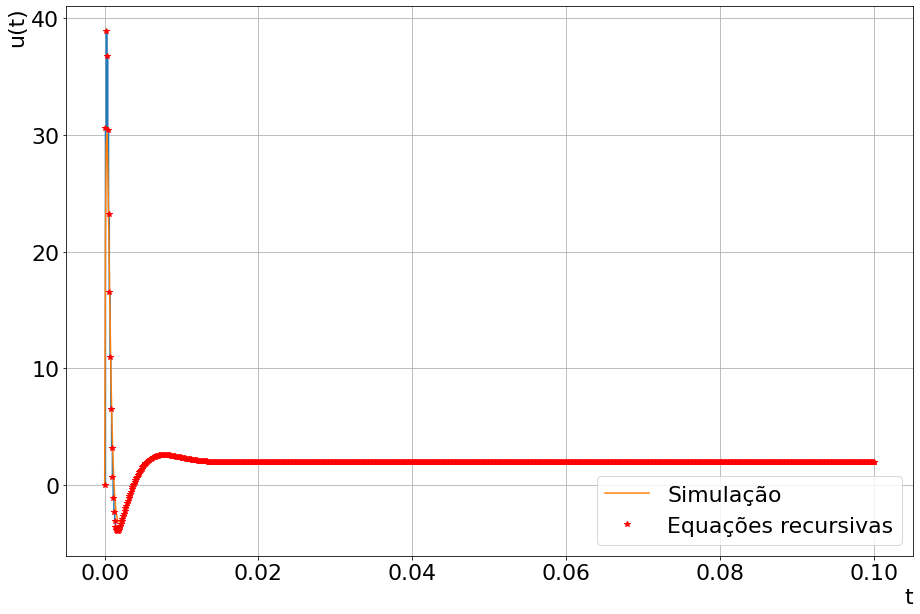

In [14]:
# Simulação do sistema controlado 'contínuo' e discreto com amplitude de 1,0 V para o sinal de entrada: 

# Amplitude do degrau de entrada.

amplitude = 1.0;

# Sistema expandido.

sistema_servo = ctrl.ss(AA,BB,CC,DD);

# Condições Iniciais.

x0 = np.matrix([[0], [0], [0], [0]]);

# Simulação do sistema.

t = np.linspace(0, 100e-3, 1000);
R = amplitude*np.heaviside(t,1);
Y, t, X = ctrl.matlab.lsim(sistema_servo, R, t, x0);

X1a = X[:,0];
X1b = X[:,1];
X1c = X[:,2];
X1d = X[:,3];

# Simulação com discretização dos integradores.
# I(z)=T/(z-1)=Xi(z)/Xi_ponto(z)=E(z)/E_ponto(z)
# xi(k)=T*xi_ponto(k-1)+xi(k-1)
# e(k)=T*e_ponto(k-1)+e(k-1)

T = 1e-4;
tfinal = 100e-3;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1);
r = amplitude*np.heaviside(k, 1);

x1 = np.zeros_like(k);
x2 = np.zeros_like(k);
x3 = np.zeros_like(k);
qsi = np.zeros_like(k);
u = np.zeros_like(k);
x1_ponto = np.zeros_like(k);
x2_ponto = np.zeros_like(k);
x3_ponto = np.zeros_like(k);
erro = np.zeros_like(k);
y = np.zeros_like(k);

# Condições iniciais (podem ser diferentes de zero).

x1[0] = x0[0];  #  para k = 0
x2[0] = x0[1];  #  para k = 0
x2[0] = x0[2];  #  para k = 0
qsi[0] = x0[3];  #  para k = 0
u[0] = -(K[0,0]*x1[0]+K[0,1]*x2[0]+K[0,2]*x3[0])+ki*qsi[0];
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
x3_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D[0,0]*u[0];  #  para k = 0
erro[0] = r[0]-y[0];  #  para k = 0

for j in range(1,Kmax+1):
    # Equações dos integradores:
    
    x1[j] = T*x1_ponto[j-1]+x1[j-1];
    x2[j] = T*x2_ponto[j-1]+x2[j-1];
    x3[j] = T*x3_ponto[j-1]+x3[j-1];    
    qsi[j] = T*erro[j-1]+qsi[j-1];
    
    # Equação da diferença do sinal de controle:
    
    u[j] = -(K[0,0]*x1[j]+K[0,1]*x2[j]+K[0,2]*x3[j])+ki*qsi[j];
    
    # Equação diferencial de estados:  Xponto=A*X+B*U
    
    x1_ponto[j] = A[0,0]*x1[j]+A[0,1]*x2[j]+A[0,2]*x3[j]+B[0,0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j]+A[1,1]*x2[j]+A[1,2]*x3[j]+B[1,0]*u[j];
    x3_ponto[j] = A[2,0]*x1[j]+A[2,1]*x2[j]+A[2,2]*x3[j]+B[2,0]*u[j];
    
    # Equação de Saída: Y=C*X+D*U
    
    y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+C[0,2]*x3[j]+D[0,0]*u[j];
    
    # Equação diferencial do erro: Eponto=R-Y
    
    erro[j] = r[j]-y[j];
    
# Equação do sinal de controle 'contínuo':

U = np.zeros_like(t);
for j in range(len(t)):
    U[j] = -(K[0,0]*X1a[j]+K[0,1]*X1b[j]+K[0,2]*X1c[j])+ki*X1d[j];
    
# Equação do erro do sistema 'contínuo':    

E = np.zeros_like(t);
for j in range(len(t)):
    E[j] = R[j] - Y[j];
    
    
# Comportamento do estado x1:
plt.figure();
plt.plot(k*T, x1, ds='steps-post');
plt.plot(t, X1a, label='Simulação');
plt.plot(k*T, x1, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{1}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do estado x2:      
plt.figure();
plt.plot(k*T, x2, ds='steps-post');
plt.plot(t, X1b, label='Simulação');
plt.plot(k*T, x2, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{2}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento do estado x3:      
plt.figure();
plt.plot(k*T, x3, ds='steps-post');
plt.plot(t, X1c, label='Simulação');
plt.plot(k*T, x3, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\mathrm{x_{3}(t)}$");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída y:
plt.figure();
plt.plot(k*T, y, ds='steps-post');
plt.plot(t, Y, label='Simulação');
plt.plot(k*T, y, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("y(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da saída do erro:                       
plt.figure();
plt.plot(k*T, erro, ds='steps-post');
plt.plot(t, E, label='Simulação');
plt.plot(k*T, erro, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("$\\dot{\\xi}$(t)");
plt.legend(loc='upper right');
plt.tight_layout();
plt.grid();
plt.show();

# Comportamento da ação de controle:                       
plt.figure();
plt.plot(k*T, u, ds='steps-post');
plt.plot(t, U, label='Simulação');
plt.plot(k*T, u, 'r*', label='Equações recursivas');
plt.xlabel("t");
plt.ylabel("u(t)");
plt.legend(loc='lower right');
plt.tight_layout();
plt.grid();
plt.show();

# 1.f) Comparação entre os valores teóricos e da simulação

In [15]:
# Especificações do sistema controlado:

# Tempo de acomodação de 5% para resposta ao degrau unitário:

tps = [];

tps.append(t[int(np.argwhere(Y == max(Y))[0][0])]);
tps.append(T*k[int(np.argwhere(y == max(y))[0][0])]);

display(Markdown('## Especificações da simulação do sistema controlado para um degrau unitário:'));
display(Markdown('### Sobressinal obtido:'));
display(Latex('$ M_{p\%} = '+str(overshoot(Y)).replace('.',',')+'\, \%$'));
display(Markdown('### Instante de pico:'));
display(Latex('$ t_{p} = '+str(tps[0]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(E[-1]).replace('.',',')+'$'));
display(Markdown('## Especificações da simulação por equações recursivas do sistema controlado para um degrau unitário:'));
display(Markdown('### Sobressinal obtido:'));
display(Latex('$ M_{p\%} = '+str(overshoot(y)).replace('.',',')+'\, \%$'));
display(Markdown('### Instante de pico:'));
display(Latex('$ t_{p} = '+str(tps[1]).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário obtido:'));
display(Latex('$ e(\infty) = '+str(erro[-1]).replace('.',',')+'$'));
display(Markdown('## Especificações do sistema desejado:'));
display(Markdown('### Sobressinal desejado:'));
display(Latex('$ M_{p\%} = '+str(Mp*100).replace('.',',')+'\, \%$'));
display(Markdown('### Instante de pico:'));
display(Latex('$ t_{p} = '+str(tp).replace('.',',')+'\, \mathrm{s}$'));
display(Markdown('### Erro para um degrau unitário desejado:'));
display(Latex('$ e(\infty) = 0$'));

## Especificações da simulação do sistema controlado para um degrau unitário:

### Sobressinal obtido:

<IPython.core.display.Latex object>

### Instante de pico:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

## Especificações da simulação por equações recursivas do sistema controlado para um degrau unitário:

### Sobressinal obtido:

<IPython.core.display.Latex object>

### Instante de pico:

<IPython.core.display.Latex object>

### Erro para um degrau unitário obtido:

<IPython.core.display.Latex object>

## Especificações do sistema desejado:

### Sobressinal desejado:

<IPython.core.display.Latex object>

### Instante de pico:

<IPython.core.display.Latex object>

### Erro para um degrau unitário desejado:

<IPython.core.display.Latex object>

In [16]:
# Tabela dos erros às entradas degrau, rampa e parábola do item a):

Markdown("""
<style>
.rendered_html table, .rendered_html td, .rendered_html th {{
    font-size: 125%;
}}
table th:first-of-type {{
    width: 33%;
}}
table th:nth-of-type(2) {{
    width: 33%;
}}
table th:nth-of-type(3) {{
    width: 33%;
}}
</style>

| Parâmetro                    | Valor Teórico       | Valor da Simulação  |
|:---------------------------- |:-------------------:|:-------------------:|
| Mp (%)                       | {}                  | {}                  |
| tp (s)                       | {}                  | {}                  |
""".format(str(round(Mp*100, 6)).replace('.',','), str(round(overshoot(Y),6)).replace('.',','), 
           str(round(tp, 9)).replace('.',','), str(round(tps[0],9)).replace('.',',')))


<style>
.rendered_html table, .rendered_html td, .rendered_html th {
    font-size: 125%;
}
table th:first-of-type {
    width: 33%;
}
table th:nth-of-type(2) {
    width: 33%;
}
table th:nth-of-type(3) {
    width: 33%;
}
</style>

| Parâmetro                    | Valor Teórico       | Valor da Simulação  |
|:---------------------------- |:-------------------:|:-------------------:|
| Mp (%)                       | 4,598791                  | 4,492519                  |
| tp (s)                       | 0,008798219                  | 0,009409409                  |
